<a href="https://colab.research.google.com/github/GopikaPavithran/Human-art-Vs-AI-generated-art/blob/main/Human_Art_vs_AI_Generated_Art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Human Touch in a Digital Age - Distinguishing Between Human and AI Art with Deep Learning**
The rise of artificial intelligence (AI) has significantly impacted many creative fields, including art. AI models are now generating visually captivating and increasingly complex artworks.These creations blur the line between human imagination and machine learning algorithms.  In 2018, a painting titled "The Portrait of Edmond de Belamy" by an AI system, shocked the art world by selling for $432,500 USD at Christie's auction house in New York.

As AI art becomes more realistic, distinguishing it from human art is turning into a more difficult but also increasingly important task. This project tackles this challenge by utilizing transfer learning with Convolutional Neural Networks (CNNs). By analyzing vast datasets of human and AI art, aims to develop a model that can effectively differentiate these artistic domains.
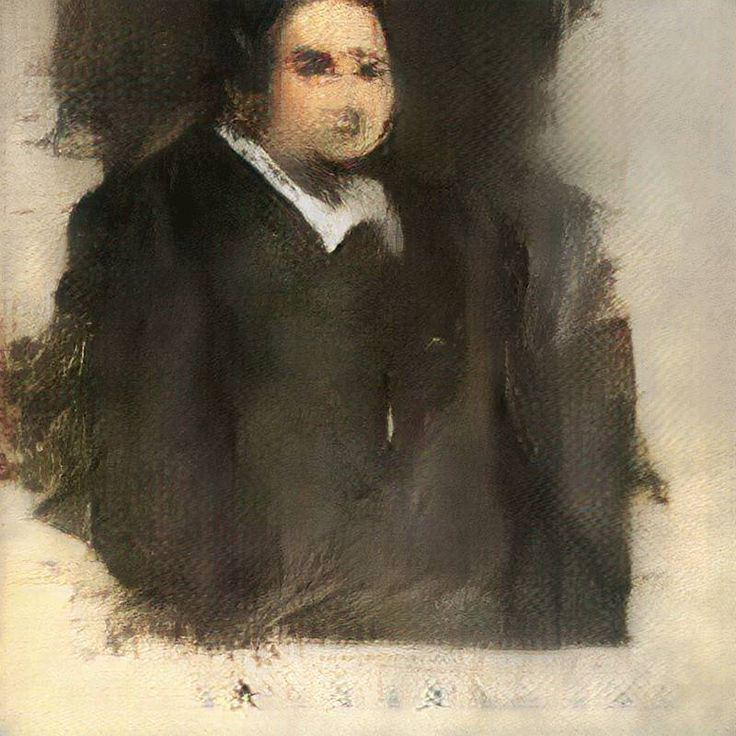

# **Importing Required Libraries**

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from shutil import copyfile
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense,Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping,ModelCheckpoint
import warnings
from keras.models import load_model
import numpy as np
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

# **Category Analysis**

In [ ]:
data='/content/drive/MyDrive/Project Datas/ai_art_classification/train'
categories=os.listdir(data)
categories

['AI_GENERATED', 'NON_AI_GENERATED']

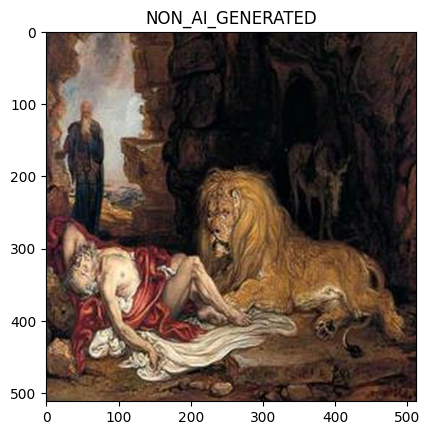

In [ ]:
random_category = random.choice(categories)
random_category_path = os.path.join(data,random_category)
images = [i for i in os.listdir(random_category_path) if os.path.isfile(os.path.join(random_category_path,i))]
random_image = random.choice(images)
random_image_path = os.path.join(random_category_path,random_image)
random_image = cv2.imread(random_image_path)
random_image=cv2.cvtColor(random_image,cv2.COLOR_BGR2RGB)
plt.imshow(random_image)
plt.title(random_category)
plt.show()

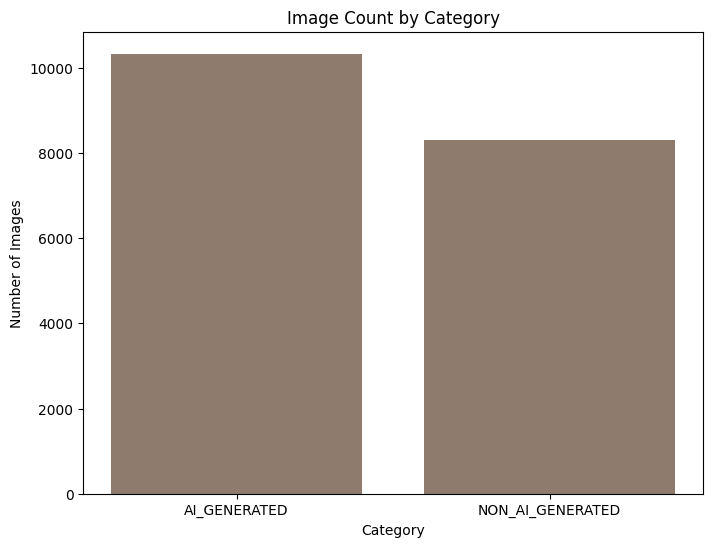

In [ ]:
category_counts = Counter()
for category in categories:
  if os.path.isdir(os.path.join(data,category)):
    category_counts[category] = len([i for i in os.listdir(os.path.join(data,category)) if os.path.isfile(os.path.join(data,category,i))])
category_names = list(category_counts.keys())
category_image_counts = list(category_counts.values())
plt.figure(figsize=(8,6))
plt.bar(category_names, category_image_counts,color='#8F7A6E')
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.title("Image Count by Category")
plt.show()

# **Pre-processing**

In [ ]:
n = 1000

for category in categories:
  new_dir = os.path.join("new_data", category)
  os.makedirs(new_dir,exist_ok=True)

for category in categories:
  category_path = os.path.join(data, category)
  image = [i for i in os.listdir(category_path) if os.path.isfile(os.path.join(category_path,i))]
  random.shuffle(image)

  for i in range(n):
    image_file = image[i]
    source_path = os.path.join(category_path, image_file)
    new_path = os.path.join("new_data", category, image_file)
    copyfile(source_path,new_path)

print("Successfully copied",n,"images from each category to 'new_data' directory.")

Successfully copied 1000 images from each category to 'new_data' directory.


In [ ]:
augmentation=ImageDataGenerator(rescale=1/225.,
                                rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                horizontal_flip=True,
                                brightness_range=[0.9, 1.1],
                                channel_shift_range=0.01,
                                validation_split=0.2)

In [ ]:
new_data_path='/content/new_data'
train_set=augmentation.flow_from_directory(new_data_path,
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='categorical',
                                           subset="training",
                                           shuffle=True)

validation_set=augmentation.flow_from_directory(new_data_path,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                subset="validation",
                                                shuffle=False)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


# **VGG16 Model**

In [ ]:
image_size=[224,224]

In [ ]:
vgg=VGG16(input_shape=image_size+[3],weights='imagenet',include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg.layers:
  layer.trainable=False

In [ ]:
x=Flatten()(vgg.output)
output=Dense(2,activation='softmax')(x)

In [ ]:
model=Model(inputs=vgg.input,outputs=output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# **Fit and Train**

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
model_filepath = "best_model.h5"
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=model_filepath,
                                   monitor="val_loss",
                                   save_best_only=True,
                                   mode="min",
                                   verbose=1)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_set,
                              validation_data=validation_set,
                              epochs=10,
                              callbacks=[early_stopping,model_checkpoint])

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.6685 - accuracy: 0.7212 
Epoch 1: val_loss improved from inf to 0.46310, saving model to best_model.h5
50/50 [==============================] - 1176s 24s/step - loss: 0.6685 - accuracy: 0.7212 - val_loss: 0.4631 - val_accuracy: 0.8200
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.3681 - accuracy: 0.8388 
Epoch 2: val_loss improved from 0.46310 to 0.45081, saving model to best_model.h5
50/50 [==============================] - 1176s 24s/step - loss: 0.3681 - accuracy: 0.8388 - val_loss: 0.4508 - val_accuracy: 0.8375
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.3182 - accuracy: 0.8550 
Epoch 3: val_loss did not improve from 0.45081
50/50 [==============================] - 1113s 22s/step - loss: 0.3182 - accuracy: 0.8550 - val_loss: 0.4706 - val_accuracy: 0.7950
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.8819 
Epoch 4: val_loss

# **Evaluation**

In [ ]:
best_epoch_index=history.history['val_loss'].index(min(history.history['val_loss']))
best_epoch_index

9

In [ ]:
print("Train Loss:",history.history['loss'][9])
print("Train Accuracy:",history.history['accuracy'][9])
print("Validation Loss:",history.history['val_loss'][9])
print("Validation Accuracy:",history.history['val_accuracy'][9])

Train Loss: 0.16209985315799713
Train Accuracy: 0.9262499809265137
Validation Loss: 0.4297507107257843
Validation Accuracy: 0.8399999737739563


In [ ]:
labels=validation_set.classes
model=load_model('/content/best_model.h5')
y_pred=model.predict(validation_set)

              precision    recall  f1-score   support

           0       0.86      0.81      0.84       200
           1       0.82      0.86      0.84       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



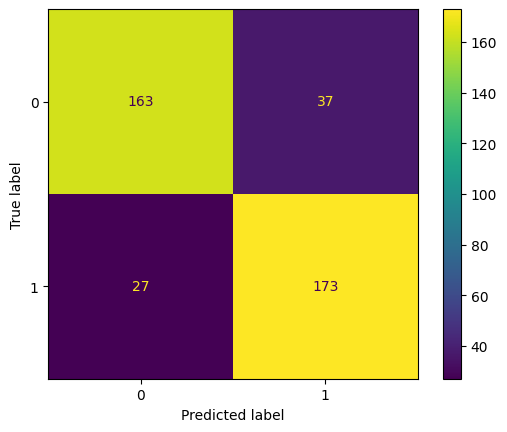

In [ ]:
y_pred = np.argmax(y_pred,axis=1)
print(ConfusionMatrixDisplay.from_predictions(labels,y_pred))
print(classification_report(labels,y_pred))

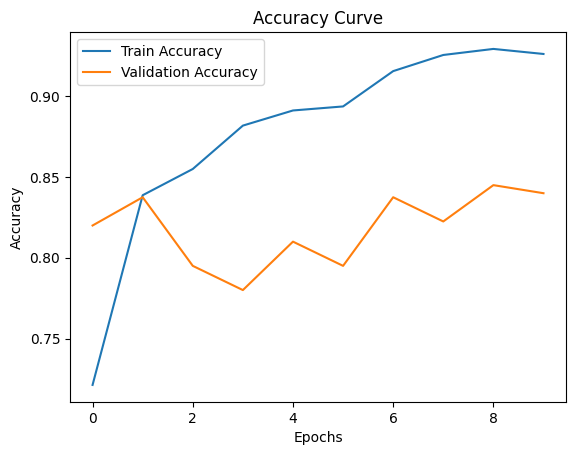

In [ ]:
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

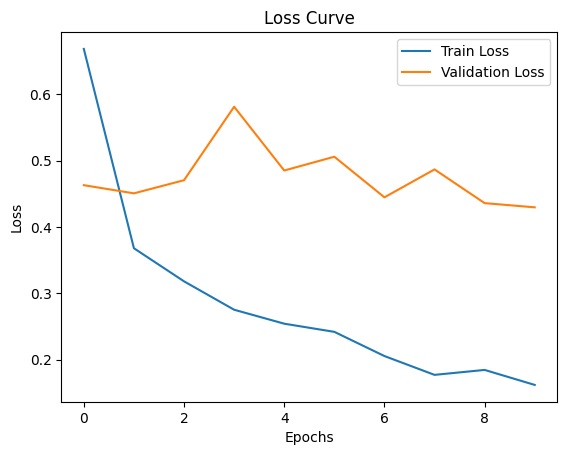

In [ ]:
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

# **Prediction on Unseen Data**

In [ ]:
def image_category(image):
  image = cv2.resize(image, (224, 224))
  image = image.reshape(1, 224, 224, 3)
  y_new = model.predict(image)
  predicted_class = y_new.argmax(axis=1)[0]
  if predicted_class == 0:
    print('AI Generated')
  else:
    print('Non AI Generated')

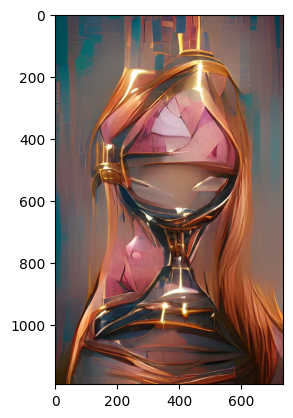

In [ ]:
image=cv2.imread('/content/drive/MyDrive/Image Data/The Hourglass.jpeg')
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
image_category(image)

1/1 [==============================] - 0s 19ms/step
AI Generated
